# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

# if Path.cwd().name != "LightGlue":
#     !git clone --quiet https://github.com/cvg/LightGlue/
# %ls
%cd LightGlue
!pip install --progress-bar off --quiet -e .



/Users/amnx/Code/MLPR/code/PicfPos/LightGlue


In [12]:
from LightGlue.lightglue import LightGlue, SuperPoint, DISK
from LightGlue.lightglue.utils import load_image, rbd
from LightGlue.lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("./")

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
device = torch.device('cpu')
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [13]:
# Take firat frame from video IMG_7131.mp4 and store it in image3
import cv2
import os
frames = []
cap = cv2.VideoCapture(str(images / "./capture/IMG_7131.mp4"))
counter = 0
#if path dosnt exists create
if not os.path.exists(str(images / "./capture/testCapture")):
    os.makedirs(str(images / "./capture/testCapture"))
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if counter%1 == 0:
        cv2.imwrite(str(images / f"./capture/testCapture/IMG_7131_{counter}.jpg"), frame)
    counter +=1
    


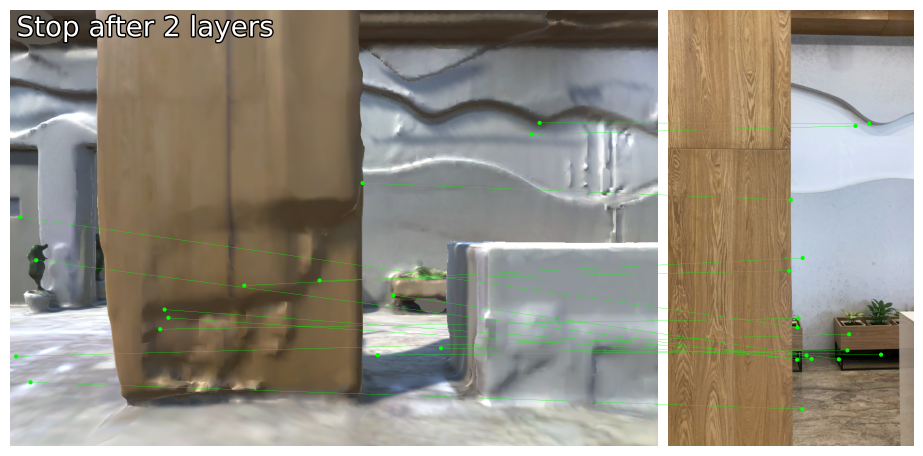

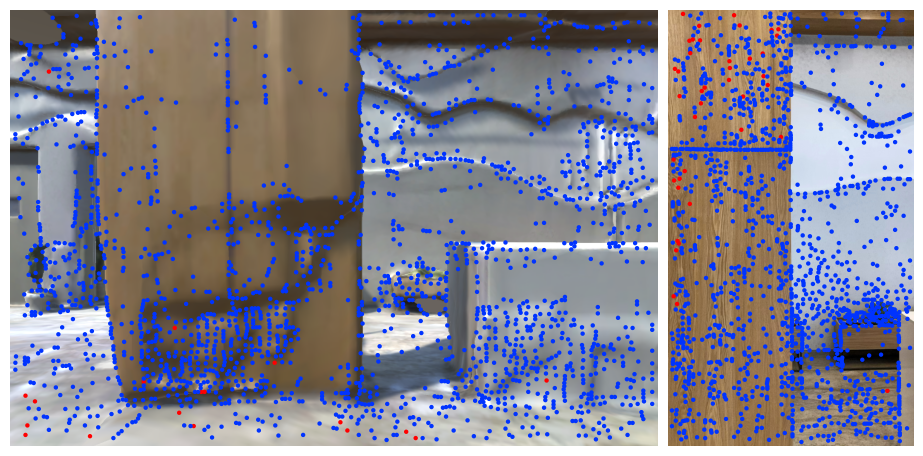

In [14]:
image0 = load_image(images / "./(-1.55, 0.00, -1.36)_1.2_270.png")
image1 = load_image(images / "./capture/testCapture/IMG_7131_0.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import imageio
import numpy as np
import tqdm

def process_images(image_list, static_image, extractor, matcher, device):
    output_images_keypoints = []
    output_images_matches = []
    for img in tqdm.tqdm(image_list):
        image = load_image(img)
        feats_static = extractor.extract(static_image.to(device))
        feats_dynamic = extractor.extract(image.to(device))
        match_results = matcher({"image0": feats_static, "image1": feats_dynamic}) # renamed variable
        feats_static, feats_dynamic, matched_pairs = [rbd(x) for x in [feats_static, feats_dynamic, match_results]] # renamed variable

        kpts_static, kpts_dynamic, matches = feats_static["keypoints"], feats_dynamic["keypoints"], matched_pairs["matches"] # use 'matched_pairs' instead of 'matches'
        m_kpts_static, m_kpts_dynamic = kpts_static[matches[:, 0]], kpts_dynamic[matches[:, 1]]

        axes = viz2d.plot_images([static_image, image])
        # print("Shape of kpts_static: ", kpts_static.shape)
        # print("Shape of kpts_dynamic: ", kpts_dynamic.shape)
        # print("Shape of matches: ", matches.shape)

        viz2d.plot_matches(m_kpts_static, m_kpts_dynamic, color="lime", lw=0.2)
        viz2d.add_text(0, f'Stop after {matched_pairs["stop"]} layers', fs=20)
        plt.savefig("temp.png")
        kpc_static, kpc_dynamic = viz2d.cm_prune(matched_pairs["prune0"]), viz2d.cm_prune(matched_pairs["prune1"]) # use 'matched_pairs' instead of 'matches'
        viz2d.plot_images([static_image, image])
        viz2d.plot_keypoints([kpts_static, kpts_dynamic], colors=[kpc_static, kpc_dynamic], ps=10)
        plt.savefig("temp1.png")
        output_images_matches.append(imageio.imread("temp.png"))
        output_images_keypoints.append(imageio.imread("temp1.png"))
    return output_images_matches, output_images_keypoints


#get a list of images
image_list = []
for i in range(0, 100):
    image_list.append(images / f"./capture/testCapture/IMG_7131_{i}.jpg")
static_image = load_image(images / "./(-1.55, 0.00, -1.36)_1.2_270.png")

output_images1, output_images2 = process_images(image_list, static_image, extractor, matcher, device)
imageio.mimsave('movie.gif', output_images1)
imageio.mimsave('movie2.gif', output_images2)


## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

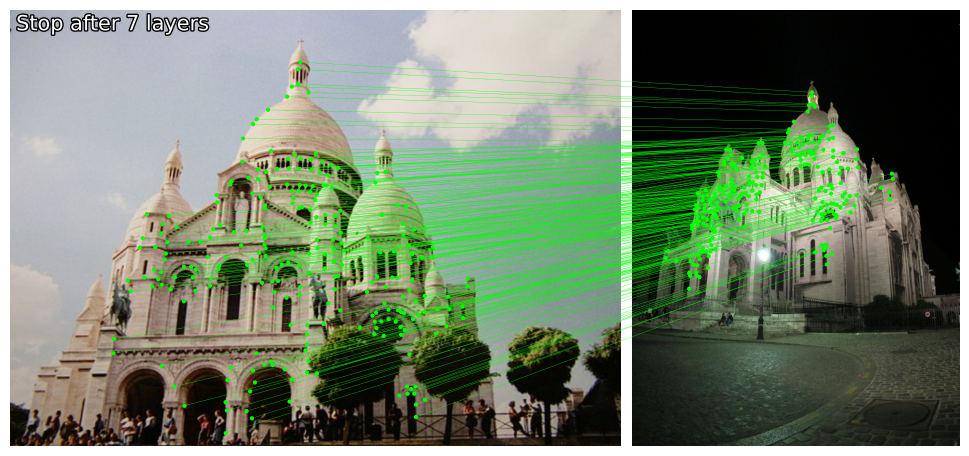

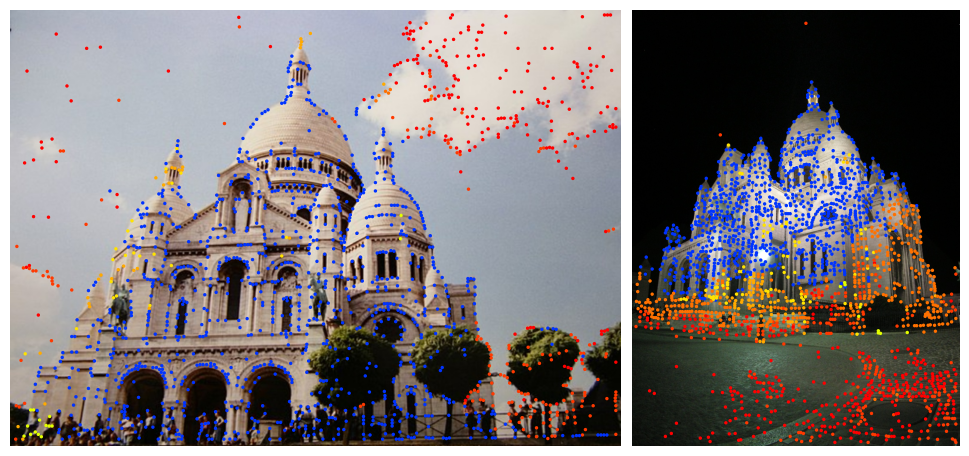

In [ ]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)